# SYSID - Trabalho (ML - SISO.LM)

Alunos: 

Pedro Henrique Cardoso Paulo</br>
Felipe da Costa Pereira

Professor: Helon

## Objetivo

TBD

## Passo 0 - Importando bibliotecas

In [1]:
# Pacotes padrao
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime

#Pipeline
from sklearn.pipeline import Pipeline

#Tratamento
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#sisidentpy
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.narmax_tools import regressor_code

#Modelos
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor

#Interface SYSID
from SYSIDPreProcessor import SYSIDRegressor

#Busca de modelos
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold

# Scores
from sklearn.metrics import r2_score

# Disabling warnings
import warnings
from sklearn.exceptions import DataConversionWarning

#Definindo random_state
rs = 85

/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Passo 0 - Importando os dados

### 0.1 - Lendo dados

In [2]:
binary = os.path.join(os.getcwd(), 'data', 'volve_compiled.pkl')
print(binary)

with open(binary, 'rb') as bin_file:
    data = pickle.load(bin_file)

/mnt/d/OneDrive/Mestrado/Semestre 02/SYSID/SYSID_Trabalho/Volve-Dataset/data/volve_compiled.pkl


In [3]:
for wellp in data['OP'].keys():
    print(wellp)

15/9-F-1 C
15/9-F-11
15/9-F-12
15/9-F-14
15/9-F-15 D
15/9-F-5


### 0.2 - Visualizando dados

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


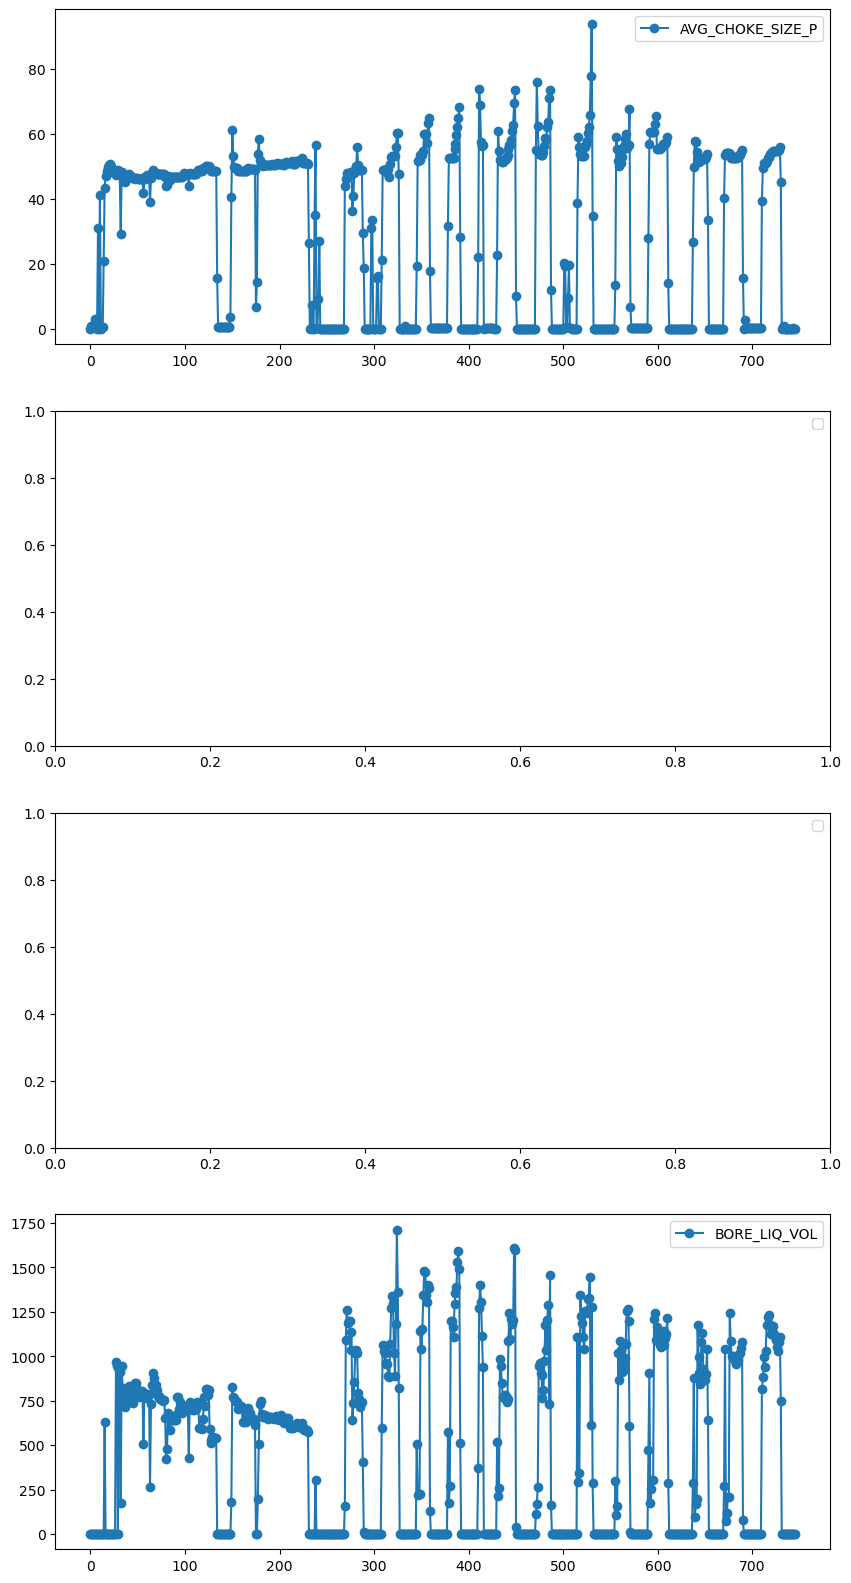

In [4]:
case = "15/9-F-1 C"
#case = "15/9-F-11"

data_case = data['OP'][case]

filt_vars_IN_Q =  [
        #'BORE_OIL_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
        #'BORE_OIL_CUM',
        #'BORE_LIQ_CUM',
        #'BORE_GAS_CUM',
        #'BORE_WAT_CUM',
]

filt_vars_IN_QINJ = [
        'BORE_WI_VOL',
        'BORE_WI_CUM',
]

filt_vars_IN_P = [
        #'AVG_DOWNHOLE_PRESSURE',
        #'AVG_WHP_P',
        #'AVG_DP_TUBING',
        #'AVG_ANNULUS_PRESS',
        'AVG_CHOKE_SIZE_P',
        #'DP_CHOKE_SIZE',
]

filt_vars_IN_T = [
        #'AVG_WHT_P',
        #'AVG_DOWNHOLE_TEMPERATURE',
]

filt_vars_OUT = [
        #'BORE_OIL_VOL',
        'BORE_LIQ_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
]

time = data_case['N']
fig, ax = plt.subplots(4,1, figsize=(10, 20))
for var in filt_vars_IN_P:
    ax[0].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_Q:
    ax[1].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_T:
    ax[2].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_OUT:
    ax[3].plot(time, data_case[var], '-o', label=var)
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

In [5]:
data_case = data_case.loc[28:,:]
#data_case = data_case[data_case['AVG_DOWNHOLE_PRESSURE']>0]
data_case = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T + filt_vars_OUT].dropna()
X1 = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T].values
y =  data_case[filt_vars_OUT].values

## Passo 1 - Separando os dados em treino e teste

### 1.1 - Definindo a parcela de treino e de teste

In [6]:
p_train = 0.7 #70% treino

### 1.2 - Separando os conjuntos

In [7]:
n_train = int(X1.shape[0]*p_train)
X1_tr = X1[:n_train,:]
y_tr = y[:n_train,:]
X1_te = X1[:,:]
y_te = y[:,:]

In [8]:
print(
    X1_tr.shape,
    X1_te.shape
)

(502, 1) (718, 1)


### 1.3 - Removendo a escala 

In [9]:
X_scale = MinMaxScaler()
y_scale = MinMaxScaler()
X_tr = X_scale.fit_transform(X1_tr)
X_te = X_scale.transform(X1_te)
y_tr = y_scale.fit_transform(y_tr)
y_te = y_scale.transform(y_te)

## Passo 2 - Declarando os modelos 

In [10]:
models = []

### 2.1 - ARMAX (sysidentpy)

In [11]:
basis_function = Polynomial(degree=1)
n = 2
na = n
nb = [n] * X1.shape[1]
ne = 1
n_terms = 6
model = FROLS(
    order_selection=True,
    ylag=na, xlag=nb,elag=ne,
    basis_function=basis_function,
    n_info_values=100,
    #n_terms=n_terms,
    model_type='NARMAX',
    #extended_least_squares=True,
)

models.append(('ARMAX', model))

### 2.2 - NARMAX (sysidentpy)

In [12]:
basis_function = Polynomial(degree=2)
n = 2
na = n
nb = [n] * X1.shape[1]
ne = 1
n_terms = 6
model = FROLS(
    order_selection=True,
    ylag=na, xlag=nb,elag=ne,
    basis_function=basis_function,
    n_info_values=100,
    #n_terms=n_terms,
    model_type='NARMAX',
    #extended_least_squares=True,
)
models.append(('NARMAX', model))

### 2.3 - Modelos de ML (sklearn)

#### 2.3.1 - Modelos

In [13]:
models_ml = [
    ('LinReg'          ,      LinearRegression(copy_X=True)), #ARX Equivalent
    ('PolyReg'         ,      Pipeline([('Poly', PolynomialFeatures(degree=2)), ('Reg', LinearRegression(copy_X=True))])), #NARX Equivalent
    ('SVM'             ,      SVR(max_iter=-1)),
    ('KNN'             ,      KNeighborsRegressor()),
    ('DecisionTree'    ,      DecisionTreeRegressor(random_state=rs)),
    ('RandomForest'    ,      RandomForestRegressor(random_state=rs)),
    ('GradientBoosting',      GradientBoostingRegressor(random_state=rs)),
    ('ExtraTrees'      ,      ExtraTreesRegressor(random_state=rs)),
]

#### 2.3.2 - Parâmetros (RandomSearchCV)

In [14]:
parameters = [
    {
        #'PCA__n_components'           : stats.uniform(loc=0.7, scale=0.3),
        'positive'                     : [True, False],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'           : stats.uniform(loc=0.7, scale=0.3),
        'Reg__positive'                : [True, False],
        'Poly__degree'                : [2, 3,],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'C'                     : stats.loguniform(1e-3, 1e3),
        'kernel'                : ['poly', 'rbf', 'sigmoid','linear'],
        'degree'                : stats.randint(2,6),
        'gamma'                 : stats.loguniform(1e-4, 1e0),
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_neighbors'           : stats.randint(1,100),
        'weights'               : ['uniform', 'distance'],
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        #'DT__criterion'              : ['gini', 'entropy'],
        'splitter'               : ['best', 'random'],
        'max_depth'              : stats.randint(5,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        'loss'                   : ['squared_error', 'absolute_error', 'huber', 'quantile'],
        'learning_rate'          : stats.loguniform(1e-5, 1e1),
        'criterion'              : ['friedman_mse', 'squared_error'],
        'subsample'              : stats.uniform(), 
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
    {
        #'PCA__n_components'          : stats.uniform(loc=0.7, scale=0.3),
        'n_estimators'           : stats.randint(5,100), #Numero de arvores
        'criterion'              : ['squared_error', 'absolute_error'],
        #'RF__criterion'              : ['gini', 'entropy'],
        'max_depth'              : stats.randint(1,20), #maxima profundidade da arvore
        'min_samples_split'      : stats.randint(2,20), #minima quantidade de amostras para splitar
        'min_samples_leaf'       : stats.randint(1,20), #minima quantidade de amostras por folha
        'max_features'           : stats.uniform(),      #maxima quantidade de features para embasar a decisao de divisao
        'max_leaf_nodes'         : stats.randint(10,150), #maxima quantidade de folhas
        #'expansor'                    : [None, PolynomialFeatures(degree=2)],
        #'nX'                          : stats.randint(2,10),
        #'ny'                          : stats.randint(2,10),
    },
]

In [15]:
kfolds = 5
niters = 10
rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)

In [16]:
n_iter = 100 #Numero de iterações do rdmsearch 

for model, params in zip(models_ml, parameters):
    rdmsearch = RandomizedSearchCV(model[1], verbose=0, scoring='r2', 
                                   param_distributions=params, n_iter=n_iter, n_jobs=6, 
                                   cv=rkf, random_state=rs)
    
    sidmodel = SYSIDRegressor(
        nX=6, ny=6,
        estimator=rdmsearch, 
        preprocessor=MinMaxScaler(),
        #expansor=PolynomialFeatures(degree=2)
        )
    
    models.append(
        (model[0], sidmodel)
    )


n_models = len(models)

In [17]:
results = {
    'MODEL':[],
    'ORDER':[],
    'R2 TRAIN OSA':[],
    'R2 TEST OSA':[],
    'R2 TRAIN FS':[],
    'R2 TEST FS':[],
    'MODEL OBJ':[],
    'PARS':[]
}

order_progression = {
    'MODEL':[],
    'ORDER':[],
    'R2 TRAIN OSA':[],
    'R2 TEST OSA':[],
    'R2 TRAIN FS':[],
    'R2 TEST FS':[],
    'MODEL OBJ':[],
}

In [18]:
for model in models:
    print(model[0])

ARMAX
NARMAX
LinReg
PolyReg
SVM
KNN
DecisionTree
RandomForest
GradientBoosting
ExtraTrees


Starting evaluation of model: ExtraTrees
    Trying order: 2
        R2 score OSA (Train): 0.8885462793105283
        R2 score OSA (Test): 0.8520146210475208
        R2 score FS (Train): 0.5502393316323767
        R2 score FS (Test): 0.5445099920199401
    Trying order: 3
        R2 score OSA (Train): 0.9073983404494619
        R2 score OSA (Test): 0.8651257450131803
        R2 score FS (Train): 0.4800788690654022
        R2 score FS (Test): 0.46856586624252095
    Trying order: 4
        R2 score OSA (Train): 0.9193220136121344
        R2 score OSA (Test): 0.8681175379009529
        R2 score FS (Train): 0.44983349675759987
        R2 score FS (Test): 0.4235155022754379
    Trying order: 5
        R2 score OSA (Train): 0.9182112595902818
        R2 score OSA (Test): 0.8653830615293536
        R2 score FS (Train): 0.524773138180765
        R2 score FS (Test): 0.4813735347933623
    Trying order: 6
        R2 score OSA (Train): 0.8725684963230258
        R2 score OSA (Test): 0.8318130450

exception calling callback for <Future at 0x7fd87893fd30 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/joblib/externals/loky/_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/joblib/parallel.py", line 385, in __call__
    self.parallel.dispatch_next()
  File "/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/joblib/parallel.py", line 834, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/joblib/parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/pedro-l

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

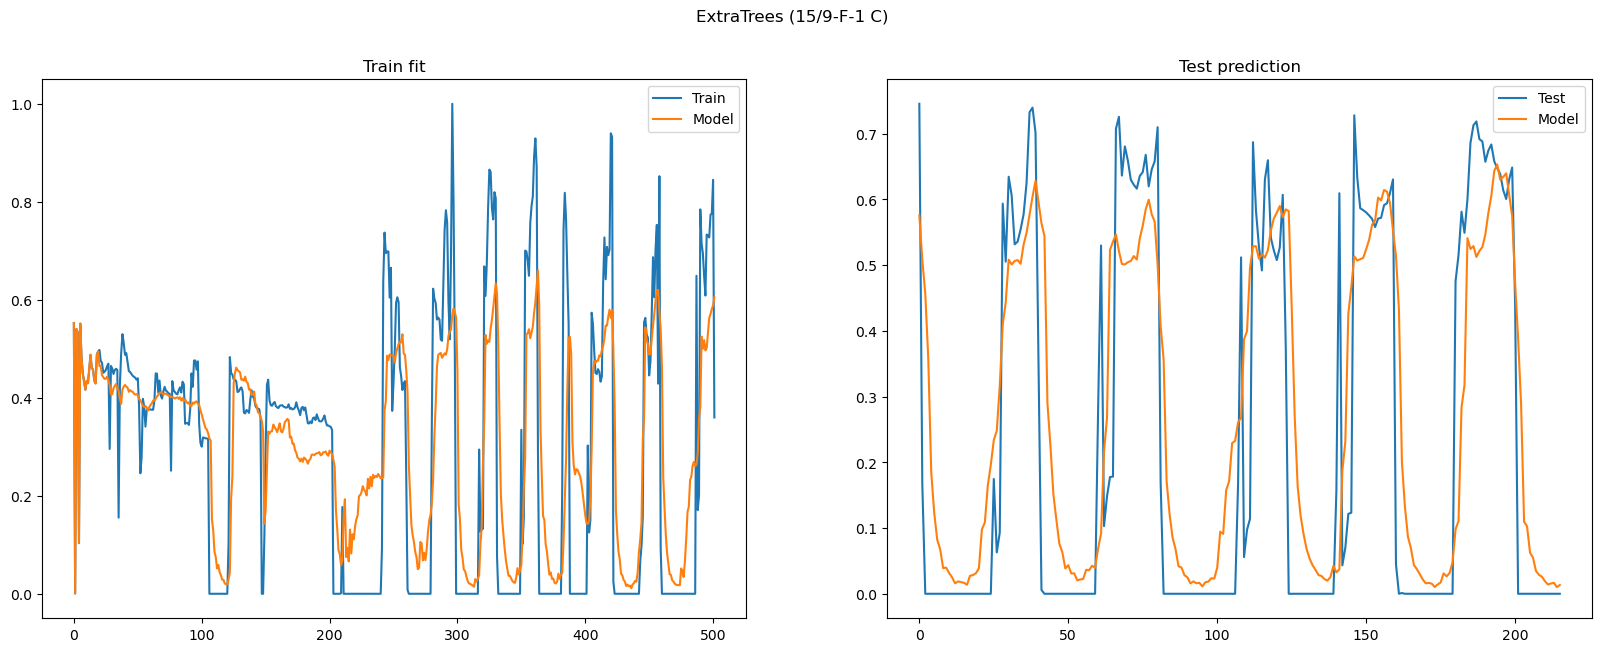

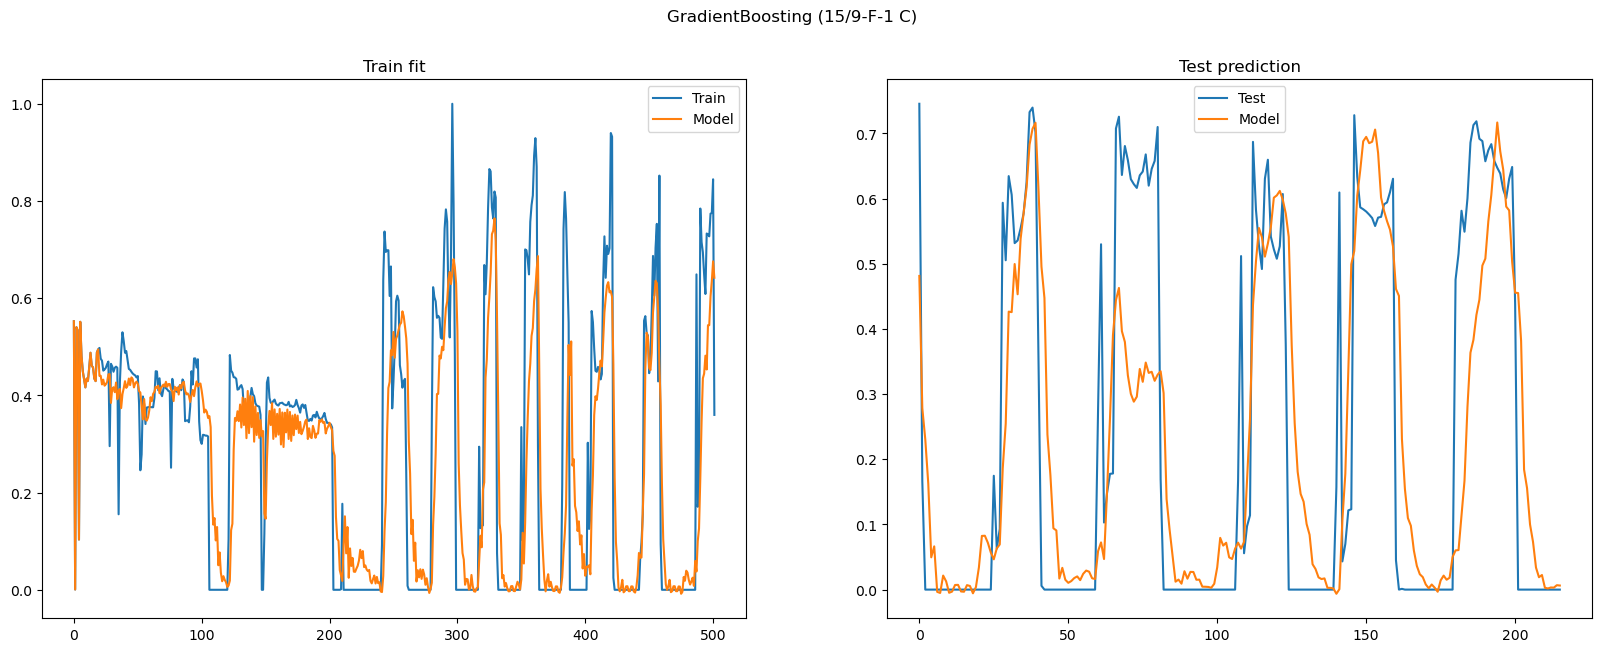

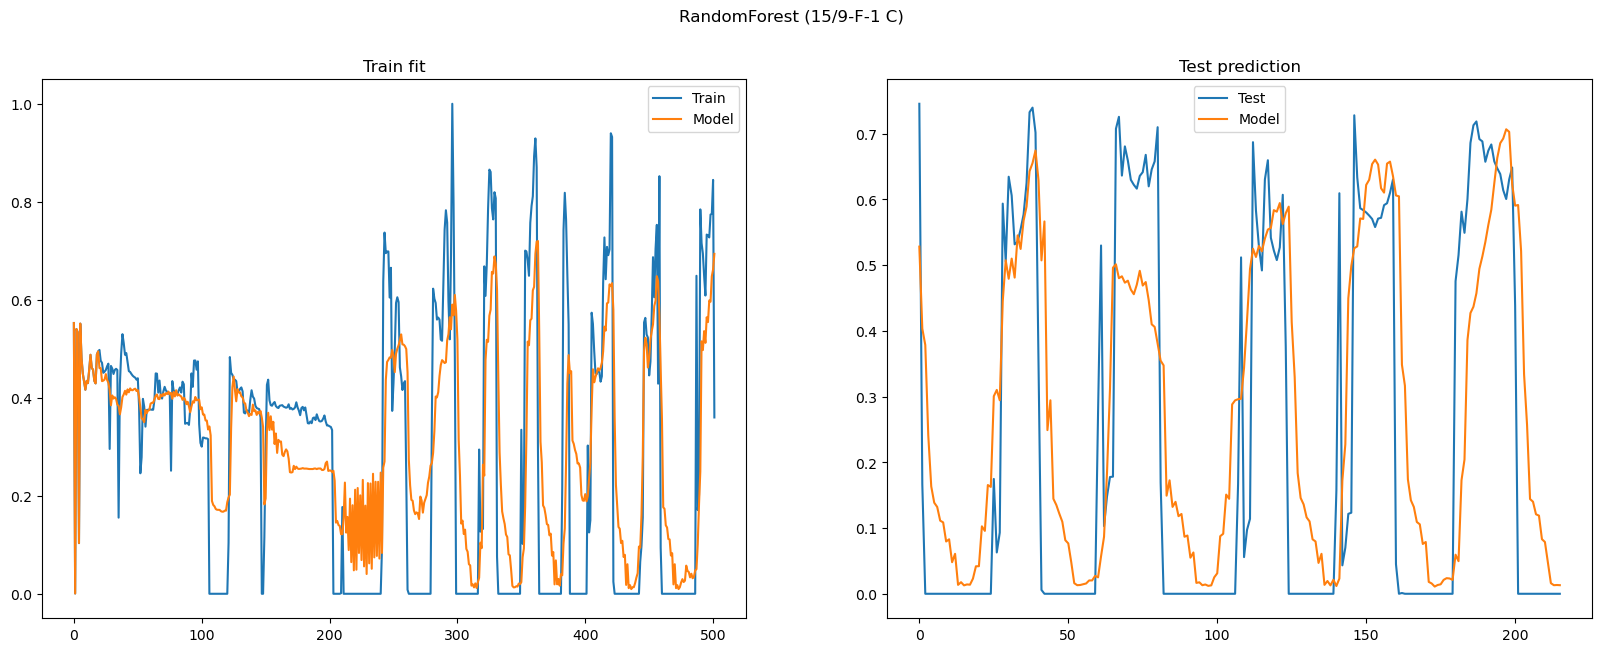

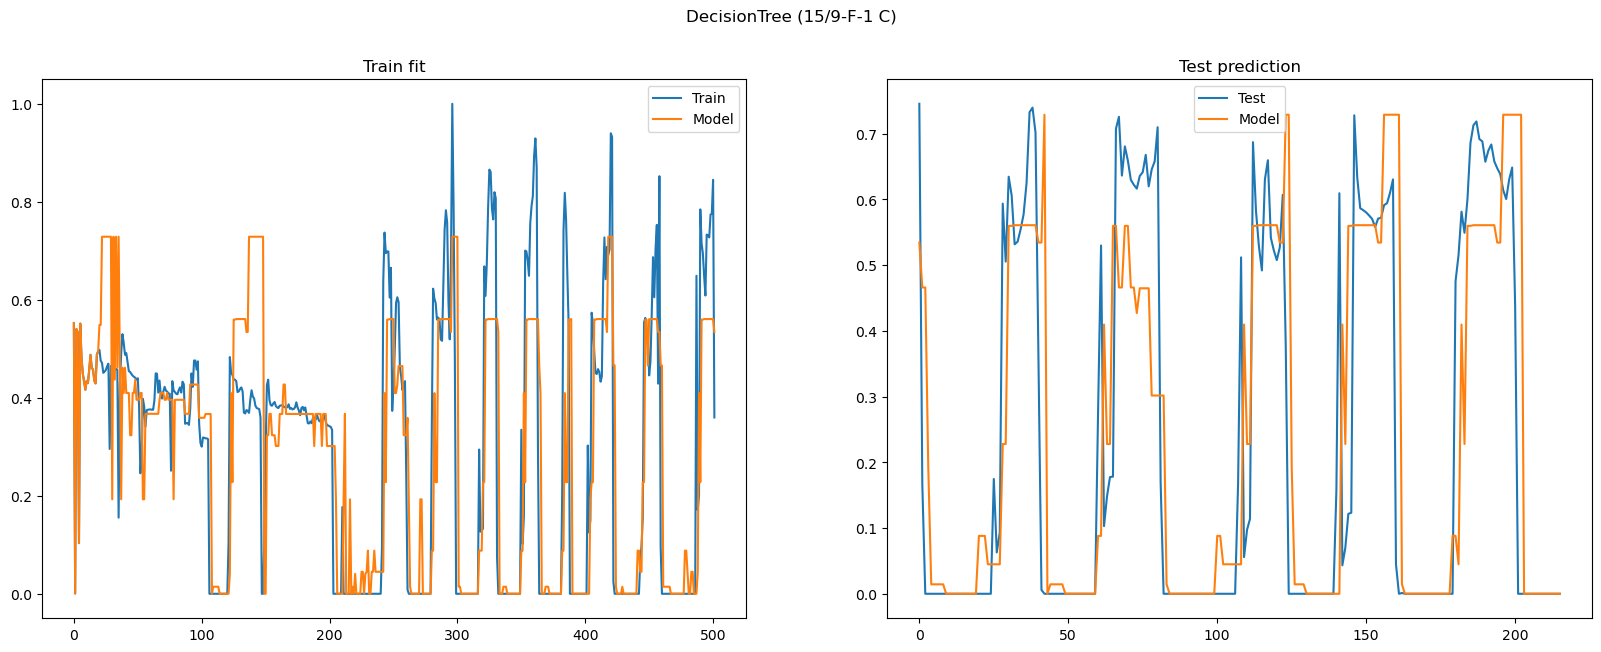

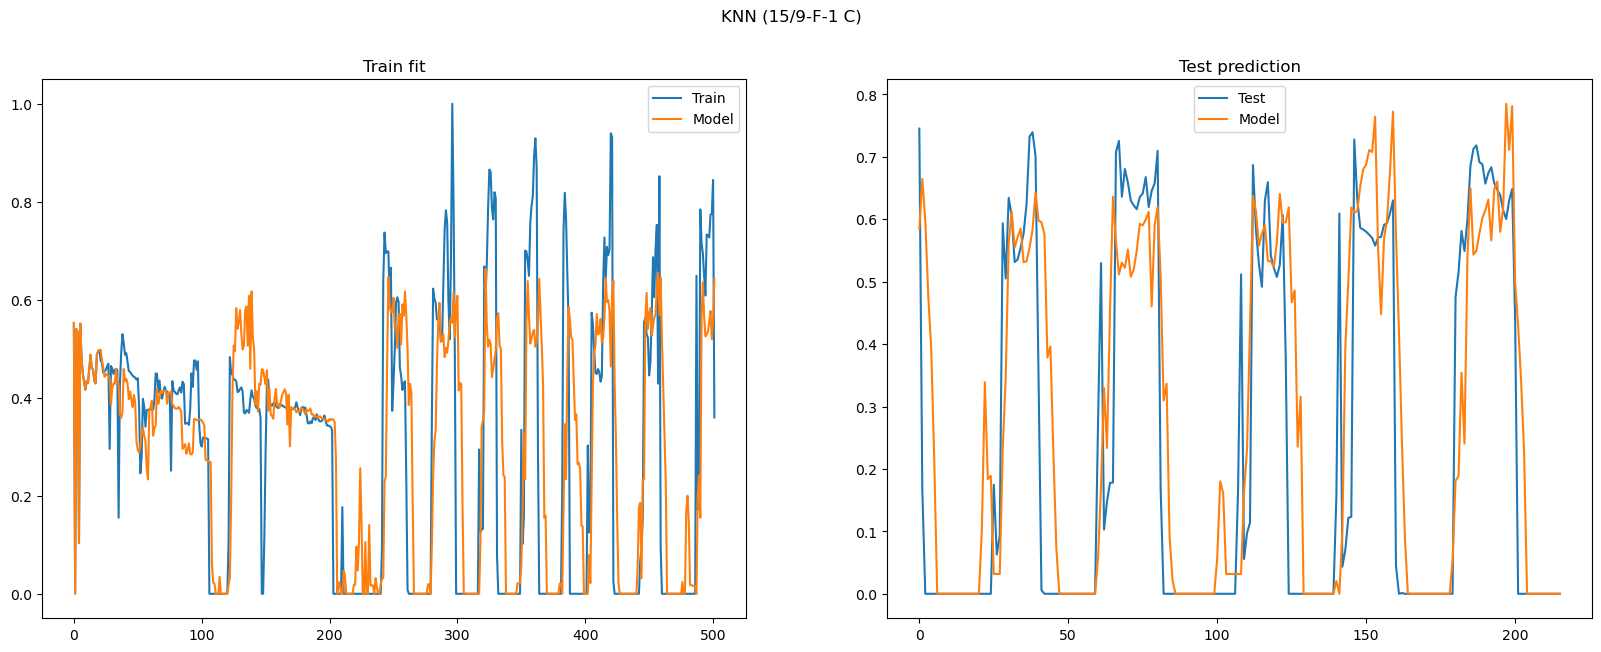

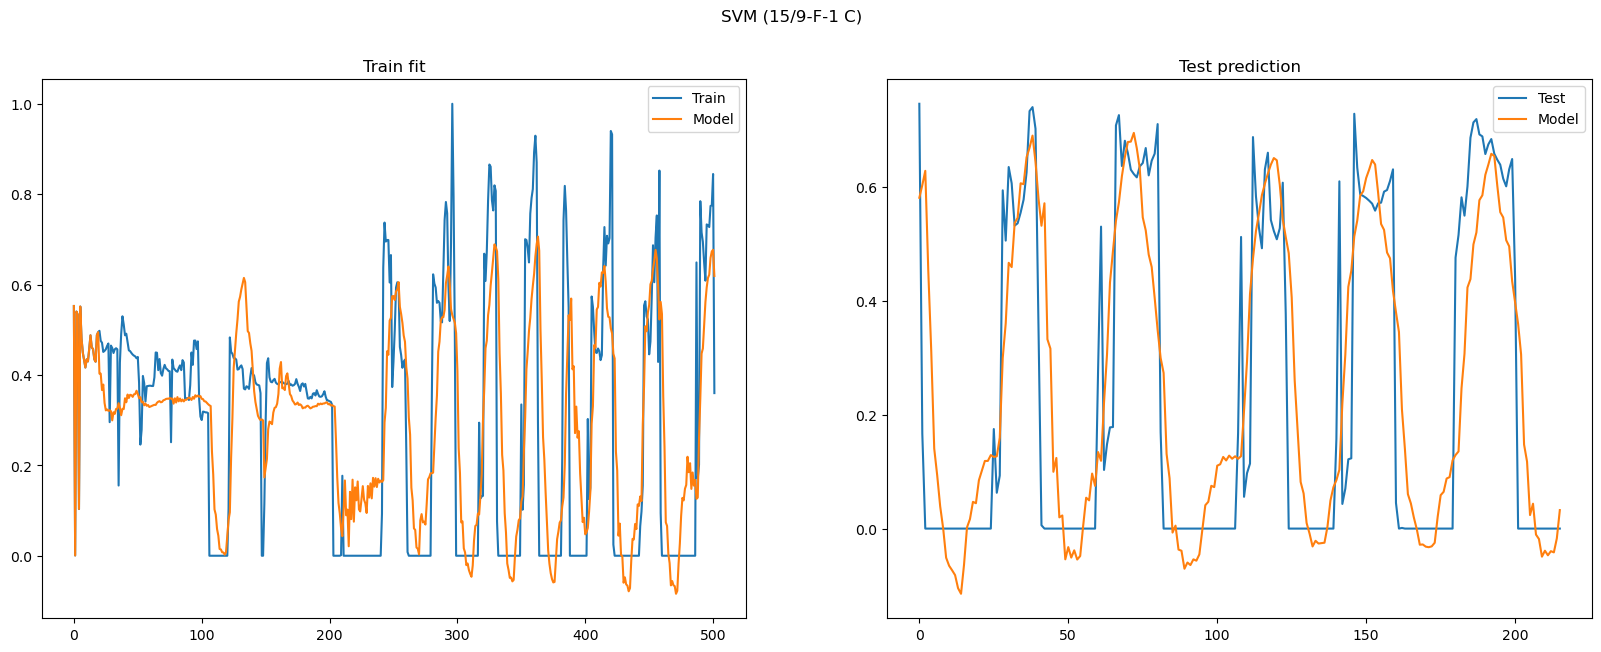

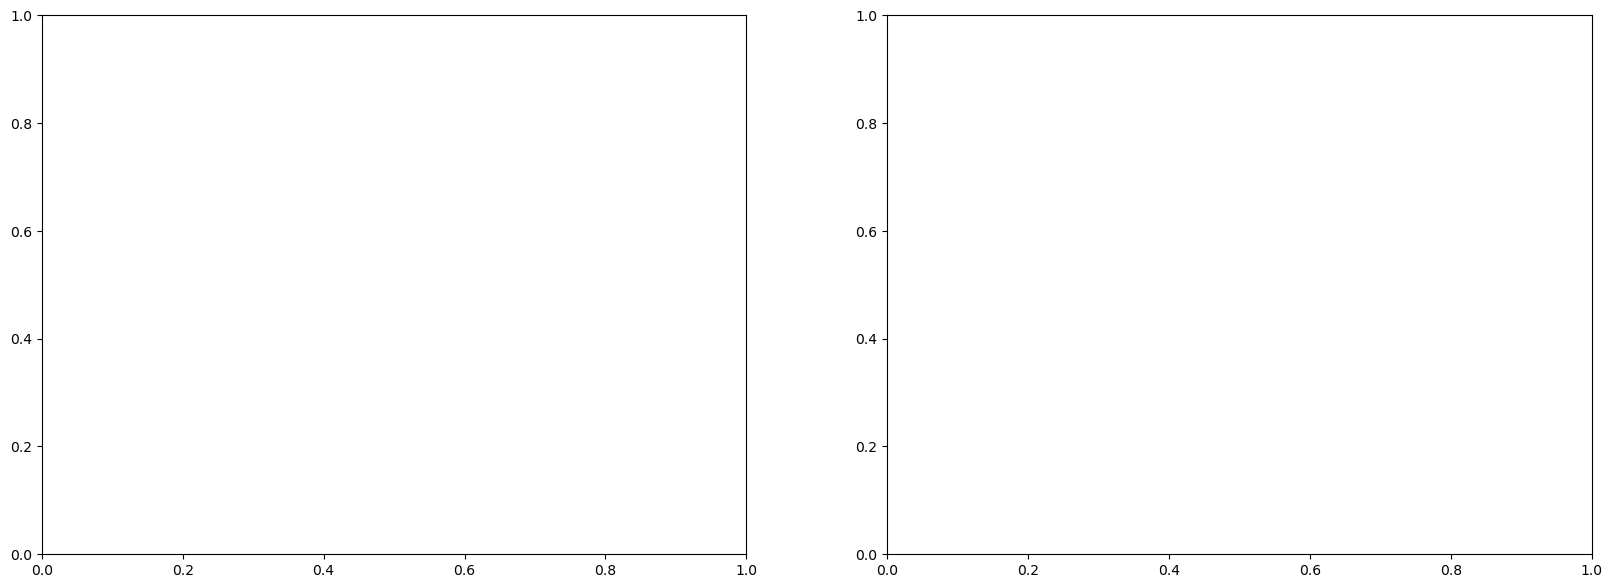

In [19]:

#fig, axs = plt.subplots(ncols=2, nrows=n_models, figsize=(25,n_models*7))
orders = range(2,21)
prefix = 'SISO'
#Loop principal, iterando sobre as listas
for model in models:#[::-1]:
    
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,7))

    model_name, sidmodel = model

    print('Starting evaluation of model: {}'.format(model_name))
    
    t0 = datetime.now()

    best_r2_tr_fs = 1e6
    best_r2_te_fs = 1e6
    best_r2_tr_osa = 1e6
    best_r2_te_osa = 1e6
    best_order = 0
    best_model = None
    
    for order in orders:
        print(f'    Trying order: {order}')
        if hasattr(sidmodel, 'nX'): # is from our package
            sidmodel.nX = order
            sidmodel.ny = order
        else:
            sidmodel.xlag = [order]*X1_tr.shape[1]
            sidmodel.ylag = order
            sidmodel.elag = order
            regressors = regressor_code(X=X1_tr,
                                        xlag=[order]*X1_tr.shape[1],
                                        ylag=order,
                                        model_type="NARMAX",
                                        model_representation="neural_network",
                                        basis_function=sidmodel.basis_function
                                        )

            n_features = regressors.shape[0]
            
            #sidmodel.n_terms = n_features

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sidmodel.fit(X=X1_tr, y=y_tr)
        r2_tr_osa = r2_score(y_tr, sidmodel.predict(X1_tr, y=y_tr, steps_ahead=1))
        r2_te_osa = r2_score(y_te, sidmodel.predict(X1_te, y=y_te, steps_ahead=1))
        r2_tr_fs = r2_score(y_tr, sidmodel.predict(X1_tr, y=y_tr))
        r2_te_fs = r2_score(y_te, sidmodel.predict(X1_te, y=y_te))
        if np.abs(r2_tr_fs - 1) < np.abs(best_r2_tr_fs - 1):
            best_r2_tr_fs = r2_tr_fs
            best_r2_te_fs = r2_te_fs
            best_r2_tr_osa = r2_tr_osa
            best_r2_te_osa = r2_te_osa
            best_order = order
            best_model = sidmodel
        order_progression['MODEL'].append(model_name)
        order_progression['ORDER'].append(order)
        order_progression['R2 TRAIN OSA'].append(r2_tr_osa)
        order_progression['R2 TEST OSA'].append(r2_te_osa)
        order_progression['R2 TRAIN FS'].append(r2_tr_fs)
        order_progression['R2 TEST FS'].append(r2_te_fs)
        order_progression['MODEL OBJ'].append(sidmodel)
        print('        R2 score OSA (Train):', r2_tr_osa)
        print('        R2 score OSA (Test):', r2_te_osa)
        print('        R2 score FS (Train):', r2_tr_fs)
        print('        R2 score FS (Test):', r2_te_fs)
        
    print()
    print('    Tempo de execução: {}'.format(datetime.now() - t0))
    print('    Best Order:', best_order)
    print('    R2 score OSA (Train):', best_r2_tr_osa)
    print('    R2 score OSA (Test):', best_r2_te_osa)
    print('    R2 score FS (Train):', best_r2_tr_fs)
    print('    R2 score FS (Test):', best_r2_te_fs)

    hist = ax[0].plot(y_tr, label='Train')
    hist = ax[0].plot(sidmodel.predict(X1_tr, y=y_tr), label='Model') 
    ax[0].set_title(f'Train fit')
    ax[0].legend()
    hist = ax[1].plot(y_te[n_train:,:], label='Test')
    hist = ax[1].plot(sidmodel.predict(X1_te, y=y_te)[n_train:,:], label='Model')
    ax[1].set_title(f'Test prediction')
    ax[1].legend()
    fig.suptitle(f'{model_name} ({case})')
    fig.savefig(os.path.join(os.getcwd(),'outputs',f'{prefix}_{model_name}.png'))
    print()
    
    results['MODEL'].append(model_name) 
    results['ORDER'].append(best_order)
    results['R2 TRAIN OSA'].append(best_r2_tr_osa)
    results['R2 TEST OSA'].append(best_r2_te_osa)
    results['R2 TRAIN FS'].append(best_r2_tr_fs)
    results['R2 TEST FS'].append(best_r2_te_fs)
    results['MODEL OBJ'].append(sidmodel)
    try:
        results['PARS'].append(sidmodel.estimator.best_params_)
    except Exception:
        results['PARS'].append(sidmodel.final_model)

In [ ]:
pd.DataFrame(results)

,MODEL,ORDER,R2 TRAIN OSA,R2 TEST OSA,R2 TRAIN FS,R2 TEST FS,MODEL OBJ,PARS
0,ExtraTrees,14,0.949342,0.887701,0.635594,0.620710,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'criterion': 'squared_error', 'max_depth': 10..."
1,GradientBoosting,15,0.963960,0.895868,0.649850,0.631856,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'criterion': 'squared_error', 'learning_rate'..."
2,RandomForest,15,0.916821,0.874120,0.631925,0.642703,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'max_depth': 15, 'max_features': 0.4383318767..."
3,DecisionTree,13,0.876747,0.818843,0.651664,0.614181,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'max_depth': 18, 'max_features': 0.3934748311..."
4,KNN,12,0.998534,0.901331,0.541543,0.525616,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'n_neighbors': 5, 'weights': 'distance'}"
5,SVM,20,0.813152,0.799860,0.572774,0.607321,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'C': 5.275248070624684, 'degree': 3, 'gamma':..."
6,PolyReg,2,0.773766,0.776327,0.371276,0.396050,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,{'Reg__positive': True}
7,LinReg,2,0.773766,0.776327,0.371276,0.396050,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,{'positive': True}
8,NARMAX,20,0.762585,0.760640,-1.000125,-0.863902,<sysidentpy.model_structure_selection.forward_...,"[[1001, 0]]"
9,ARMAX,20,0.762585,0.760640,-1.000125,-0.863902,<sysidentpy.model_structure_selection.forward_...,[[1001]]


In [ ]:
order_progression = pd.DataFrame(order_progression)
order_progression

,MODEL,ORDER,R2 TRAIN OSA,R2 TEST OSA,R2 TRAIN FS,R2 TEST FS,MODEL OBJ
0,GradientBoosting,2,0.832005,0.815926,0.308915,0.295907,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
1,ExtraTrees,2,0.888546,0.852015,0.550239,0.544510,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
2,ExtraTrees,3,0.907398,0.865126,0.480079,0.468566,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
3,ExtraTrees,4,0.919322,0.868118,0.449833,0.423516,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
4,ExtraTrees,5,0.918211,0.865383,0.524773,0.481374,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
...,...,...,...,...,...,...,...
186,ARMAX,16,0.762153,0.760359,-1.028279,-0.882236,<sysidentpy.model_structure_selection.forward_...
187,ARMAX,17,0.762167,0.760368,-1.025308,-0.880301,<sysidentpy.model_structure_selection.forward_...
188,ARMAX,18,0.762207,0.760394,-1.020102,-0.876911,<sysidentpy.model_structure_selection.forward_...
189,ARMAX,19,0.762501,0.760585,-1.006721,-0.868197,<sysidentpy.model_structure_selection.forward_...


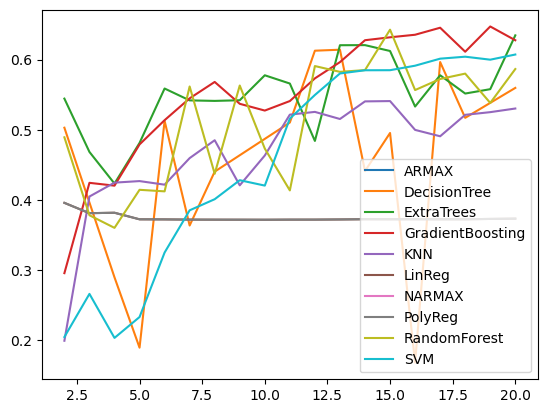

In [ ]:
fig, ax = plt.subplots()
for model in np.unique(order_progression.MODEL):
    #if model == 'DT': continue
    data_filt = order_progression[order_progression.MODEL == model]
    data_filt = data_filt[data_filt['R2 TEST FS'] >= 0]
    ax.plot(data_filt.ORDER, data_filt['R2 TEST FS'], label=model)
ax.legend()

In [ ]:
binary = os.path.join(os.getcwd(), 'outputs', 'SISO_ml.pkl')
print(binary)

with open(binary, 'wb') as bin_file:
    pickle.dump((X1_tr, y_tr, X1_te, y_te, results, order_progression), bin_file)

/mnt/d/OneDrive/Mestrado/Semestre 02/SYSID/SYSID_Trabalho/Volve-Dataset/outputs/SISO_ml.pkl
